In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
import ClassCOMPAS     as CC ###

# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# import the formation channel scripts
from ClassFormationChannels_5mainchannels import * 
# import the comsic integration (SFRD) scripts
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data 



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


### the following block of code just creates list for the SFRD model names as they occur in the csv files 

In [2]:
MSSFRnameslist = []
MSSFRnameslist.append('000') # add phenomenological 

for ind_SFR, SFR in enumerate(SFRs):
	ind_x = ind_SFR+1
	for ind_GSMF, GSMF in enumerate(GSMFs):
		ind_y = ind_GSMF + 1
		for ind_MZ, MZ in enumerate(MZs):
			ind_z = ind_MZ +1

			MSSFRnameslist.append('%s%s%s'%(ind_x, ind_y, ind_z))
            
            
MSSFRnameslistCSV = ['.0.0.0', '.1.1.1', '.1.1.2', '.1.1.3', '.1.2.1', '.1.2.2', '.1.2.3', '.1.3.1', '.1.3.2', '.1.3.3', '.2.1.1', '.2.1.2', '.2.1.3', '.2.2.1', '.2.2.2', '.2.2.3', '.2.3.1', '.2.3.2', '.2.3.3', '.3.1.1', '.3.1.2', '.3.1.3', '.3.2.1', '.3.2.2', '.3.2.3', '.3.3.1', '.3.3.2', '.3.3.3']
for ind_SFRD, SFRD in enumerate(MSSFRnameslistCSV):
    if SFRD in ['.0.0.0', '.2.3.1', '.3.1.2']:
        print(ind_SFRD, SFRD)
        print(MSSFRnameslist[ind_SFRD])
        
        
        


0 .0.0.0
000
16 .2.3.1
231
20 .3.1.2
312


In [3]:
def calculateMaxVariations(whichRate='intrinsic', DCO_ind=0, BPSnameslist=BPSnameslist, whichGraph='FormationChannels', whichChannel='classic'):
    """ 
    calculates the variations in binary population synthesis and SFRD models. 
    
    it returns minMaxMSSFR, minMaxBPS, which are an array of the min and maximum values
    marginalized over BPS or SFRD, for each SFRD or BPS model respectively. 
    These values can be used to caluclate the <sigma_xyz> and <sigma_mu> 
    and the min & max overall values that are quoted in Fig 9. 
    
    """
    
    minMaxMSSFRrates = []
    minMaxBPSrates = []
    meanScatterMSSFRrates = []
    meanScatterBPSrates = []
    

    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']



    
    

    existingBPSnameslist_ind = np.arange(len(BPSnameslist))

    
    
    
    minMaxMSSFR     = np.zeros((2,len(MSSFRnameslist)))
    percentileMSSFR = np.zeros((3,len(MSSFRnameslist)))
    minMaxBPS       = np.zeros((2,len(existingBPSnameslist_ind)))
    percentileBPS   = np.zeros((3,len(existingBPSnameslist_ind)))
    
    
    List_formationchannelOptions = ['All', 'classic', \
                      'stable B no CEE', \
                    'immediate CE',\
                 r'double-core CE', 'other']
    
    ind_formationchannelOptions = [0,1,2,3,4,5]
    
    dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}
        
    
    headernames = ['All', 'channel I', 'channel II', 'channel III', 'channel IV', 'channel V']

        
    for ind_L, MSSFRname in enumerate(MSSFRnameslist):
        # open right file. 
        if whichGraph=='general':
            stringgg =  'AllDCOsimulation'
            
        elif whichGraph=='FormationChannels':
            stringgg = 'AllDCOsimulation_formation_channels'
            
            
            
        df_name = '/Users/floorbroekgaarden/Projects/BlackHole-NeutronStar/csvFiles/rates_MSSFR_Models_' + TypesLabels[DCO_ind] + '_' + stringgg +  '.csv' 
        df = pd.read_csv(df_name, index_col=0).T
        rates_L = df[MSSFRnameslistCSV[ind_L]]

        if whichRate =='intrinsic':
            if whichGraph=='general':
                rates = np.asarray(rates_L[::2])
            elif whichGraph=='FormationChannels':
                ind_wanted = dictFormationChannelIndex[whichChannel]*2
                rates = np.asarray(rates_L[ind_wanted::12][0:nModels])
                totalrates = np.asarray(rates_L[0::12][0:nModels])
                rates = rates/totalrates # fractional rate
                

        elif whichRate=='observed':
            if whichGraph=='general':
                rates = np.asarray(rates_L[1::2])
            elif whichGraph=='FormationChannels':
                ind_wanted = (dictFormationChannelIndex[whichChannel]*2)+1
                rates = np.asarray(rates_L[ind_wanted::12][0:nModels])
                totalrates = np.asarray(rates_L[1::12][0:nModels])
                rates = rates/totalrates # fractional rate


            ylabel = r'$\mathcal{R}_{\rm{det}} \, \, [\rm{yr}^{-1}] $'

        # over different models
        
        rates = np.asarray(rates)[existingBPSnameslist_ind]
        

        
        minMaxMSSFR[:,ind_L] = np.asarray([np.min(rates), np.max(rates)])
        percentileMSSFR[:,ind_L] = np.asarray([np.percentile(a=rates,q=50), np.percentile(a=rates,q=5), np.percentile(a=rates,q=95)])

  
        for ind, modelname in enumerate(np.asarray(BPSnameslist)[existingBPSnameslist_ind]):
            # open right file. 
            if whichGraph=='general':
                stringgg =  'AllDCOsimulation'

            elif whichGraph=='FormationChannels':
                stringgg = 'AllDCOsimulation_formation_channels'
                
            df_name = '/Users/floorbroekgaarden/Projects/BlackHole-NeutronStar/csvFiles/rates_MSSFR_Models_' + TypesLabels[DCO_ind]  + '_' + stringgg + '.csv' 
            df = pd.read_csv(df_name, index_col=0)

            if whichRate =='intrinsic':
                # open right headername. 
                if whichGraph=='general':
                    namez0 = modelname + ' intrinsic (z=0) [Gpc^{-3} yr^{-1}]'
                    rates = np.asarray(df[namez0])
                 

                elif whichGraph=='FormationChannels':
                    ind_channel = dictFormationChannelIndex[whichChannel]
                    namez0 = modelname + headernames[ind_channel] + ' intrinsic (z=0) [Gpc^{-3} yr^{-1}]'
                    rates = np.asarray(df[namez0])
                    namez0All = modelname + headernames[0] + ' intrinsic (z=0) [Gpc^{-3} yr^{-1}]'
                    ratesAll = np.asarray(df[namez0All])
                    rates = rates/ratesAll
                
                
        

            elif whichRate=='observed':
                if whichGraph=='general':
                    nameObs = modelname + ' observed (design LVK) [yr^{-1}]'
                    rates =np.asarray( df[nameObs])
            
                elif whichGraph=='FormationChannels':
                    ind_channel = dictFormationChannelIndex[whichChannel]
                    nameObs = modelname + headernames[ind_channel] + ' observed (design LVK) [yr^{-1}]'
                    rates =np.asarray( df[nameObs])
                    nameObsAll = modelname + headernames[0] + ' observed (design LVK) [yr^{-1}]'
                    ratesAll = np.asarray(df[nameObsAll])
                    rates = rates/ratesAll
            

            minMaxBPS[:,ind] = np.asarray([np.min(rates), np.max(rates)])


    return minMaxMSSFR, minMaxBPS




In [4]:
def plotRatesMSSFRandModelsAnalysisBHNSColors(whichRate='intrinsic', ylims=[0,1]):
    ncols=1
    nrows=1
    # 20, 12
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,6), 
                  gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
    
    Types      = ['BBH', 'BHNS', 'BNS']
    TypesLabels      = ['BHBH', 'BHNS', 'NSNS']
    TypeColours = ['#8da0cb','#66c2a5','#fc8d62']
    ObservedRatesList = [BHBHrate0, BHNSrate0, NSNSrate0]
    
    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
    MSSFRcolors = sns.color_palette("husl", len(MSSFRnameslist)) 
    
#     nrDATAready = 12
    nModels=15
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    BPScolors       = sns.color_palette("husl", len(BPSnameslist))
    
    for ind_t, DCOtype in enumerate(Types):
        if DCOtype=='BHNS':
        
            for ind_L, MSSFRname in enumerate(MSSFRnameslist):

                stringgg = 'AllDCOsimulation'
                df_name = '/Users/floorbroekgaarden/Projects/BlackHole-NeutronStar/csvFiles/rates_MSSFR_Models_' + TypesLabels[ind_t] + '_' + stringgg + '.csv' 
                df = pd.read_csv(df_name, index_col=0).T
                rates_L = df[MSSFRnameslistCSV[ind_L]]


                if whichRate =='intrinsic':
                    rates = rates_L[::2][0:nModels]
    #                     print(rates)
                    if ind_L==0:
                        print('the intrinsic fiducial rate for ', DCOtype ,'=',rates[0]) 

                    ylabel = r'$\mathcal{R}_{\rm{m}}^{{0}} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'







                elif whichRate=='observed':
                    rates = rates_L[1::2][0:nModels]
                    if ind_L==0:
                        print('the observed fiducial rate for ', DCOtype ,'=',rates[0]) 
                    ylabel = r'$\mathcal{R}_{\rm{det}} \, \, [\rm{yr}^{-1}] $'




                if MSSFRname=='000':
                    COLOR= TypeColours[ind_t]#  'crimson'
                    zorder = 100
                    label=MSSFRnameslist[ind_L]
                    ls = MSSFRlinestyles[0]
                    ALPHA=1
                elif MSSFRname=='231':
                    COLOR=TypeColours[ind_t]#'teal'
                    zorder=10
                    label=MSSFRnameslist[ind_L] 
                    ls = MSSFRlinestyles[1]
#                     print('label=', label)
                    ALPHA=1
                elif MSSFRname=='312':
                    COLOR=TypeColours[ind_t]#'c'
                    zorder=10
                    label=MSSFRnameslist[ind_L]
                    ls = MSSFRlinestyles[2]
#                     print('label=', label)
                    ALPHA=1
                else:
                    COLOR=TypeColours[ind_t]# 'lightgray' #MSSFRcolors[ind_L]
                    zorder=2
                    label=None    
                    ls = MSSFRlinestyles[0]
                    ALPHA=0.1

                axe.plot(range(len(rates)), rates, c='k', lw=3, label=None, zorder=zorder, alpha=ALPHA, linestyle=ls)
                axe.scatter(range(len(rates)), rates, c=BPScolors, s=120, label=label, zorder=zorder+1, alpha=ALPHA, linestyle=ls)
                # plot fiducial result with a star
                if ind_L==0:
                    axe.scatter(range(len(rates))[0], rates[0],\
                                       c=BPScolors[0], s=400, label=label, \
                                       zorder=1000, marker='*', edgecolor='black')


            # calculate statistics: 
            minMaxPerMSSFR, minMaxPerBPS = calculateMaxVariations(whichRate=whichRate, DCO_ind=ind_t, BPSnameslist=BPSnameslist,whichGraph='general')

            print('mean scatter per MSSFR:')
            print(np.mean((minMaxPerMSSFR[1] / minMaxPerMSSFR[0])))
            meanScatterDueToBPS = int(np.round(np.mean((minMaxPerMSSFR[1] / minMaxPerMSSFR[0])),0))

            print('mean scatter per BPS:')
            print(np.mean(minMaxPerBPS[1]/ minMaxPerBPS[0]))    
            meanScatterDueToMSSFR = int(np.round(np.mean(minMaxPerBPS[1]/ minMaxPerBPS[0]),0))

            textt_MSSFR = r'$\langle \sigma_{\rm{xyz}}\rangle \approx %s \times$'%meanScatterDueToMSSFR
            textt_BPS = r'$\langle \sigma_{\mu}\rangle \approx %s \times$'%meanScatterDueToBPS
            minn, maxx = np.min(minMaxPerBPS[0]), np.max(minMaxPerBPS[1])
            
            
        
            textt_min = roundAndFormat(minn)
            textt_max = roundAndFormat(maxx)
            
            if whichRate=='intrinsic':
                textt_min = r'$\mathcal{R}^0_{\rm{m,min}} = %s $'%textt_min
                textt_max = r'$\mathcal{R}^0_{\rm{m,max}} = %s $'%textt_max
            elif whichRate=='observed':
                textt_min = r'$\mathcal{R}_{\rm{det,min}} = %s $'%textt_min
                textt_max = r'$\mathcal{R}_{\rm{det,max}} = %s $'%textt_max
                
            axe.text(0.905, 0.1, s=textt_MSSFR, rotation = 0, fontsize = fs-4, color = 'k', ha = 'left',transform=axe.transAxes)#, weight = 'bold')
            axe.text(0.905, 0.2, s=textt_BPS, rotation = 0, fontsize = fs-4, color = 'k', ha = 'left',transform=axe.transAxes)#, weight = 'bold')

            
            ## MAKE RANGE ERROR LINE: 
            resN = 20
            scatterline_x = -0.25 * np.ones(resN)
            scatterline_y = np.linspace(minn,maxx, resN)
            axe.errorbar(x=-0.17, y=minn+((maxx-minn)/2), yerr=(maxx-minn)/2, capsize=3, ecolor='k', elinewidth=2)
            textt_ratioMinMax = r'$%s \times$'%int(np.round(maxx/minn,1)) 
            yvalue =  (10**(np.log10(minn)+((np.log10(maxx)-np.log10(minn))/2)) )  #10**(np.log10(minn+((maxx-minn)))/2)
            axe.text(-0.17, yvalue, s=textt_ratioMinMax, rotation=90, fontsize = fs-4, color='k', ha='right', va='center')


            axe.text(-0.6, minn, s=textt_min, rotation = 0, fontsize = fs-4, color = 'k', ha = 'left', va='top')#,transform=axe.transAxes)#, weight = 'bold')
            axe.text(-0.6, maxx, s=textt_max, rotation = 0, fontsize = fs-4, color = 'k', ha = 'left', va='bottom')#,transform=axe.transAxes)#, weight = 'bold')



            xmin = -0.8
            xmax = nModels -0.5 # change to len(df.T)
            xx = np.linspace(xmin,xmax,15)

            if whichRate=='intrinsic':
                min_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][0]
                max_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][1]
                axe.fill_between(xx, min_obs_rate, max_obs_rate, alpha=0.2, color='gray', zorder=0)

                # for BHNS plot that its a upper limit
                if ind_t==1:
                    axe.scatter(xx, max_obs_rate, marker=11, color='gray', zorder=0, s=45)

            else:
                for ll in [0.01, 0.1, 1, 10, 100, 1000, 1E4]:
                    axe.plot(xx, ll*np.ones_like(xx), c='lightgray', linestyle='dashdot', lw=1, zorder=0)
                axe.set_ylim(ylims[0], ylims[1] )


            # make up axes
            if ind_t ==1:
                xlabel = r'\textbf{binary population synthesis model} $\mu$'
            else:
                xlabel=r'  $\_$ '

            axe.set_xlim(xmin, xmax)
            axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False)
            axe.set_yscale('log')

    
            physicalnames = []
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(r'\textbf{%s}'%(bps_model) )
            axe.set_xticks(range(nModels))
            axe.set_xticklabels(physicalnames,  fontsize=fs) #rotation=55,

            axe.set_ylim(ylims[0], ylims[1] )


            
            
            ##### SECOND AXIS ######
            physicalnames=[]
            for ind_m, bps_model in enumerate(BPSnameslist):
                physicalnames.append(alphabetPhysicalNameDictWithEnter[bps_model])
            ax2y = axe.twiny()
            ax2y.set_xlim(xmin, xmax)

            ax2y.set_xticks(range(nModels))
            ax2y.set_xticklabels(physicalnames, fontsize=fs-8, rotation=30)#, orientation=30)    
            


    plt.tight_layout()
    plt.subplots_adjust(wspace=0.34, hspace=0.16)#2)

    plt.savefig('./Rates_' +whichRate + '_BHNS_Colors.png', dpi=600, transparent=False)
    plt.savefig('./Rates_' +whichRate + '_BHNS_Colors.pdf', transparent=False)
    plt.show()
    plt.close()

    return




# Plot figure 9 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


the intrinsic fiducial rate for  BHNS = 43.022776513041364
mean scatter per MSSFR:
28.772061195775308
mean scatter per BPS:
7.442662091284803


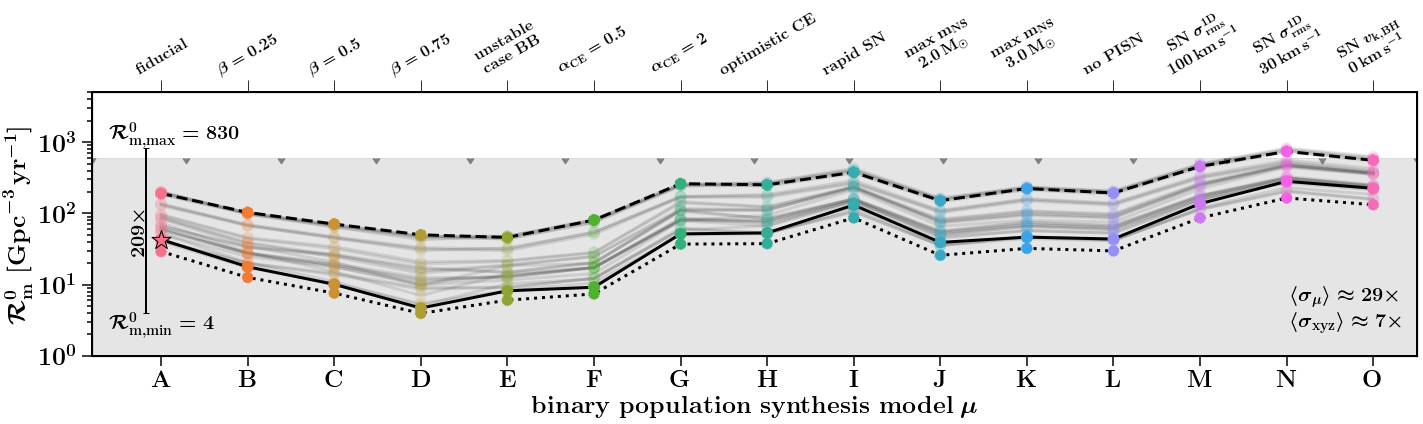

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


the observed fiducial rate for  BHNS = 10.827595525955116
mean scatter per MSSFR:
22.896332518411068
mean scatter per BPS:
8.350307303272379


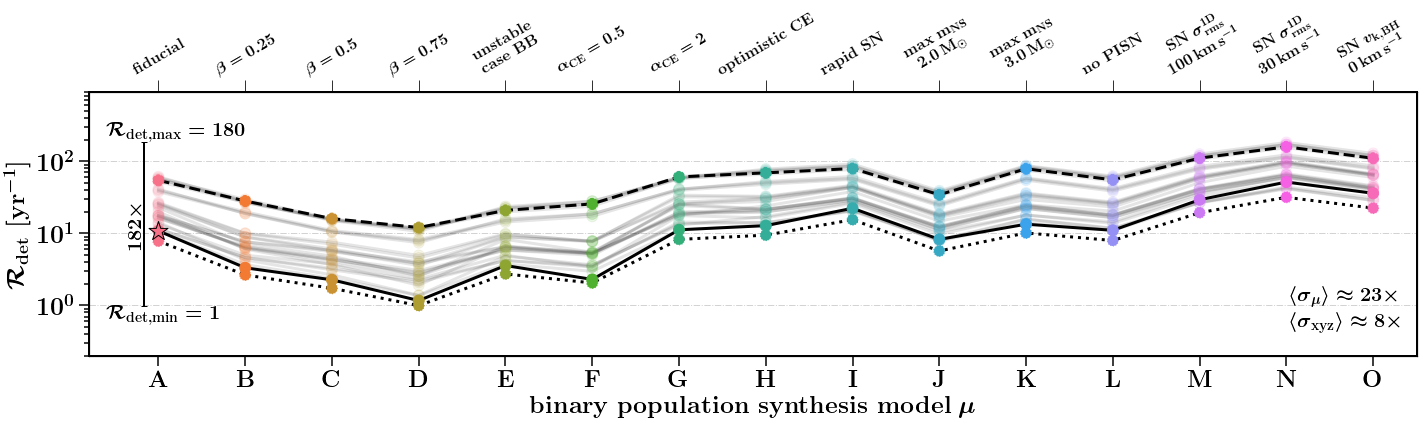

In [5]:
# ylims: min_y and max y values for the range of the y-axis that we want to show
ylims =[1,5000]
plotRatesMSSFRandModelsAnalysisBHNSColors(whichRate='intrinsic', ylims=ylims)

ylims = [0.2, 900]
plotRatesMSSFRandModelsAnalysisBHNSColors(whichRate='observed', ylims=ylims)